# Create your model

#### 1. Install Dependencies and Setup

In [127]:
import numpy as np #type: ignore
import pandas as pd #type: ignore
import tensorflow as tf #type: ignore
from tensorflow.keras.models import Model #type: ignore
from tensorflow.keras import backend as K  #type: ignore
import matplotlib.pyplot as plt #type: ignore
import matplotlib # type: ignore
import os
import cv2 #type: ignore
import yaml #type: ignore
import re
from sklearn.model_selection import train_test_split, KFold #type: ignore
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score #type: ignore
from imblearn.metrics import specificity_score #type: ignore
import openpyxl #type: ignore
from openpyxl.drawing.image import Image #type: ignore
from openpyxl.utils import get_column_letter #type: ignore
from io import BytesIO
from PIL import Image as PILImage #type: ignore
import seaborn as sns #type: ignore
import tempfile
from mpl_toolkits.axes_grid1 import make_axes_locatable #type: ignore

#### 2. Get the name of the metabolite, rename YAML file and build access paths


In [128]:
def get_metabolite_name():
    current_dir = os.getcwd()
    
    # Get the parent directory name (which should be the metabolite name)
    metabolite_name = os.path.basename(current_dir)
    
    return metabolite_name

In [129]:
def rename_files():
    metabolite_name = get_metabolite_name().lower()  

    # List files in the current directory
    files = os.listdir(os.getcwd())

    # Trouver les fichiers YAML et notebook
    yaml_file = next((f for f in files if f.endswith('.yml') or f.endswith('.yaml')), None)

    # Rename the files
    if yaml_file:
        new_yaml_name = f"config_{metabolite_name}.yml"
        os.rename(yaml_file, new_yaml_name)
        print(f"Renamed {yaml_file} to {new_yaml_name}")
    else:
        print("No YAML file found")

rename_files()

Renamed config_ecg.yml to config_ecg.yml


#### Select model version & load YAML config

In [178]:
if __name__ == "__main__":
    metabolite_name = get_metabolite_name()
    
    version = 1 ## SELECT THE VERSION ##


def load_config(metabolite_name, version):
    yaml_file = f'config_{metabolite_name.lower()}.yml'
    with open(yaml_file, 'r') as file:
        config = yaml.safe_load(file)
    
    # Convert version to integer if it's a whole number
    version_int = int(version) if isinstance(version, float) and version.is_integer() else version
    
    if version_int not in config['versions']:
        raise ValueError(f"Version {version} not found in config file")
    
    return config['versions'][version_int], str(version)

config, version_str = load_config(metabolite_name, version)

In [131]:
def construct_path(metabolite_name, path_type):
    # Get current working directory and move up two levels
    base_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    print(f"Base directory: {base_dir}")  

    if path_type in ["abnormal", "normal"]:
        return os.path.join(base_dir, "data", metabolite_name, path_type)
    elif path_type == "models":
        return os.path.join(base_dir, "models", metabolite_name)
    elif path_type == "excel":
        return os.path.join(base_dir, f"model_results_{metabolite_name}.xlsx")
    else:
        raise ValueError("Invalid path type")
    
path_invalid = construct_path(metabolite_name, "abnormal")
path_valid = construct_path(metabolite_name, "normal")

Base directory: c:\Users\Biosfer\Desktop\kaggle_dataset_ECG
Base directory: c:\Users\Biosfer\Desktop\kaggle_dataset_ECG


#### 3. Load Images

In [132]:
def load_images(path, label):
    images = []
    labels = []
    data = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            img_path = os.path.join(path, filename)
            # Read PNG with all channels
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            # Adding this correction turns the number of channels from 4 to 3, which affects the condition below!!
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None and img.shape == (547, 671, 3): # height, width, channels
                images.append(img)
                labels.append(label)
                data.append((img, label, filename))
    df = pd.DataFrame(data, columns=['Image', 'Label', 'Filename'])
    df.set_index('Filename', inplace=True)

    return images, labels, df


# Load NA (invalid) images
na_images, na_labels, df_0 = load_images(path_invalid, 0)  # 0 for invalid

# Load normal (valid) images
normal_images, normal_labels, df_1 = load_images(path_valid, 1)  # 1 for valid

# Combine the data
X = na_images + normal_images
Y = na_labels + normal_labels

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Merging the two dfs
df = pd.concat([df_0, df_1])

In [133]:
# Better practice is to create dataframes, and have each row with its identifier, the image, and the label
print("Invalid df description")
print("----------------------------------")
print(df_0.shape)
print(df_0.dtypes)
print(" ")
print("Valid df description")
print("----------------------------------")
print(df_1.shape)
print(df_1.dtypes)
print(" ")
print("Valid complete df description")
print("----------------------------------")
print(df.shape)
print(df.dtypes)
print(" ")

Invalid df description
----------------------------------
(1000, 2)
Image    object
Label     int64
dtype: object
 
Valid df description
----------------------------------
(1000, 2)
Image    object
Label     int64
dtype: object
 
Valid complete df description
----------------------------------
(2000, 2)
Image    object
Label     int64
dtype: object
 


#### 4. data pre-processing

In [134]:
# Preprocess images with normalization and standardization
def preprocess_images(images, coords, crop_size, resize_shape):
    processed_images = []

    for img in images:
        # Crop the image
        cropped_img = img[coords[0]:(
            coords[0] + crop_size[0]), coords[1]:(coords[1]+crop_size[1])]

        # Resize the image
        resized_img = cv2.resize(
            cropped_img, resize_shape, interpolation=cv2.INTER_AREA)

        # Normalize pixel values
        normalized_img = resized_img.astype(np.float32) / 255.0

        processed_images.append(normalized_img)

    return processed_images

In [135]:
coords = config['preprocess']['coords']
crop_size = config['preprocess']['crop_size']
resize_shape = tuple(config['preprocess']['resize_shape'])


X_processed = preprocess_images(
    df['Image'].tolist(), coords, crop_size, resize_shape)

df['Processed'] = X_processed

C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\828594880.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preprocessed_image = df['Processed'][index]


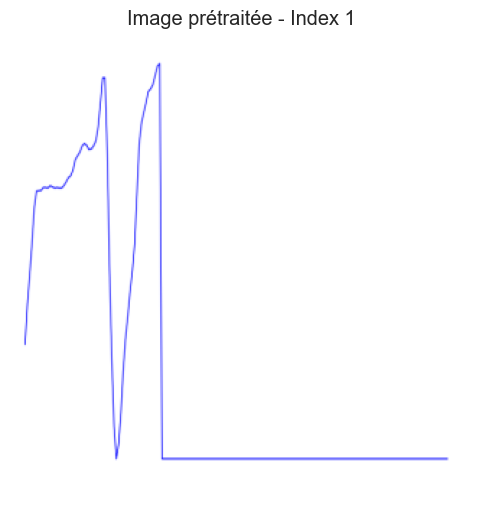

In [136]:
# Sélectionne une image prétraitée à afficher
index = 1  # Vous pouvez changer l'index pour afficher une autre image
preprocessed_image = df['Processed'][index]

# Affichage de l'image prétraitée
plt.figure(figsize=(8, 6))
plt.imshow(preprocessed_image)
plt.title(f"Image prétraitée - Index {index}")
plt.axis('off')
plt.show()

#### 5. Split data

In [137]:
# Ensure splits contain at least one NA sample
def ensure_na_in_split(X, Y, na_label=0):

    # Shuffle the data
    np.random.seed(24)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    # Split data into training (80%), validation (15%), and test (5%)
    # First, split into training (80%) and temporary (20%)
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)
    # Second, split the temporary set into validation (15% of total) and test (5% of total)
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=0.25, random_state=42, stratify=Y_temp)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Split and ensure each set has at least one NA sample
X_train, X_val, X_test, Y_train, Y_val, Y_test = ensure_na_in_split(
    df['Processed'], df['Label'])

C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\2656941208.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = X[indices]
C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\2656941208.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y = Y[indices]


In [138]:
X_train_array = np.stack(X_train.values)
X_val_array = np.stack(X_val.values)
X_test_array = np.stack(X_test.values)

In [139]:
# Convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train_array, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val_array, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_array, dtype=tf.float32)

Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_val_tensor = tf.convert_to_tensor(Y_val, dtype=tf.float32)
Y_test_tensor = tf.convert_to_tensor(Y_test, dtype=tf.float32)

# Print the shapes of the arrays
print(f'Shape of X_train_tensor: {X_train_tensor.shape}')
print(f'Shape of X_val_tensor: {X_val_tensor.shape}')
print(f'Shape of X_test_tensor: {X_test_tensor.shape}')
print(f'Shape of Y_train_tensor: {Y_train_tensor.shape}')
print(f'Shape of Y_val_tensor: {Y_val_tensor.shape}')
print(f'Shape of Y_test_tensor: {Y_test_tensor.shape}')

# Print the number of NA samples in each split
print(f'Number of NA samples in Y_train: {np.sum(Y_train == 0)}')
print(f'Number of NA samples in Y_val: {np.sum(Y_val == 0)}')
print(f'Number of NA samples in Y_test: {np.sum(Y_test == 0)}')

Shape of X_train_tensor: (1600, 320, 320, 3)
Shape of X_val_tensor: (300, 320, 320, 3)
Shape of X_test_tensor: (100, 320, 320, 3)
Shape of Y_train_tensor: (1600,)
Shape of Y_val_tensor: (300,)
Shape of Y_test_tensor: (100,)
Number of NA samples in Y_train: 800
Number of NA samples in Y_val: 150
Number of NA samples in Y_test: 50


In [140]:
# Matching Filenames for Validation and Test Sets Based on Processed Images

# Ensure 'Processed' column contains preprocessed images
df_all = df.reset_index()
df_all['Processed'] = df_all['Image'].apply(
    lambda img: preprocess_images([img], coords, crop_size, resize_shape)[0]
)

def find_filenames_by_label(X_set, Y_set, label, df_all):
    """
    Finds filenames in a given dataset for a specific label.
    
    Args:
        X_set (np.ndarray): Array of images (e.g., X_val or X_test).
        Y_set (np.ndarray): Array of labels corresponding to X_set.
        label (int): The target label to filter.
        df_all (pd.DataFrame): DataFrame containing 'Processed' images and 'Filename'.

    Returns:
        list: Filenames corresponding to the target label.
    """
    # Find matching filenames
    filenames = [
        df_all.loc[
            df_all['Processed'].apply(lambda x: np.array_equal(x, img)).idxmax(),
            'Filename'
        ]
        for img in X_set
    ]
    # Filter filenames by label
    return [filenames[i] for i in np.where(Y_set == label)[0]]

# Validation set
label_0_val_filenames = find_filenames_by_label(X_val, Y_val, label=0, df_all=df_all)
print("Validation set filenames with label 0:")
print("\n".join(label_0_val_filenames))
print(f"\nTotal number of validation samples with label 0: {len(label_0_val_filenames)}")

# Test set
label_0_test_filenames = find_filenames_by_label(X_test, Y_test, label=0, df_all=df_all)
print("Test set filenames with label 0:")
print("\n".join(label_0_test_filenames))
print(f"\nTotal number of test samples with label 0: {len(label_0_test_filenames)}")

Validation set filenames with label 0:
ECG_0827_abnormal.png
ECG_0699_abnormal.png
ECG_0625_abnormal.png
ECG_0238_abnormal.png
ECG_0478_abnormal.png
ECG_0593_abnormal.png
ECG_0492_abnormal.png
ECG_0064_abnormal.png
ECG_0767_abnormal.png
ECG_0100_abnormal.png
ECG_0188_abnormal.png
ECG_0957_abnormal.png
ECG_0125_abnormal.png
ECG_0660_abnormal.png
ECG_0568_abnormal.png
ECG_0378_abnormal.png
ECG_0963_abnormal.png
ECG_0618_abnormal.png
ECG_0536_abnormal.png
ECG_0803_abnormal.png
ECG_0384_abnormal.png
ECG_0005_abnormal.png
ECG_0101_abnormal.png
ECG_0804_abnormal.png
ECG_0974_abnormal.png
ECG_0719_abnormal.png
ECG_0942_abnormal.png
ECG_0282_abnormal.png
ECG_0633_abnormal.png
ECG_0472_abnormal.png
ECG_0206_abnormal.png
ECG_0896_abnormal.png
ECG_0622_abnormal.png
ECG_0939_abnormal.png
ECG_0216_abnormal.png
ECG_0685_abnormal.png
ECG_0808_abnormal.png
ECG_0903_abnormal.png
ECG_0200_abnormal.png
ECG_0712_abnormal.png
ECG_0353_abnormal.png
ECG_0365_abnormal.png
ECG_0075_abnormal.png
ECG_0366_abnorm

#### 6. Build Deep Learning Model

In [154]:
# Custom F1 Score metric to evaluate precision and recall balance

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.true_positives.assign_add(tf.reduce_sum(y_pred * y_true))
        self.false_positives.assign_add(tf.reduce_sum(y_pred * (1 - y_true)))
        self.false_negatives.assign_add(tf.reduce_sum((1 - y_pred) * y_true))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

In [179]:
# Build model

exec(config['code'])
model.summary()  # type: ignore

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 318, 318, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 159, 159, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 157, 157, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 78, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 76, 76, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     5,914,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,924,849 (22.60 MB)

 Trainable params: 5,924,849 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

#### 7. Train the model

In [180]:
exec(config['training'])

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.5979 - f1_score: 0.5005 - loss: 0.7584 - val_accuracy: 0.7867 - val_f1_score: 0.5756 - val_loss: 0.4292
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.8060 - f1_score: 0.5488 - loss: 0.4455 - val_accuracy: 0.8900 - val_f1_score: 0.5263 - val_loss: 0.2565
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.8777 - f1_score: 0.5495 - loss: 0.2751 - val_accuracy: 0.8600 - val_f1_score: 0.4689 - val_loss: 0.3165
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9095 - f1_score: 0.5302 - loss: 0.2263 - val_accuracy: 0.8700 - val_f1_score: 0.4879 - val_loss: 0.3120
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.9311 - f1_score: 0.5450 - loss: 0.1705 - val_accuracy: 0.9133 - val_f1_score: 0.5168 - val_loss: 0.2492
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.9559 - f1_score: 0.5190 - loss: 0.1213 - val_accuracy: 0.8900 - val_f1_score: 

##### Display activation maps

In [181]:
# Warning : each images need to have a different name

def display_image_filtered(name_image, model, layer_name, image):
    inp = model.inputs
    out1 = model.get_layer(layer_name).output
    feature_map_1 = tf.keras.Model(inputs=inp, outputs=out1)
    
    # The image is already processed, so we just need to expand dimensions
    input_img = np.expand_dims(image, axis=0)
    
    f = feature_map_1.predict(input_img)
    dim = f.shape[3]
    
    print(f'{layer_name} | Features Shape: {f.shape}')
    print(f'Dimension {dim}')
    
    fig = plt.figure(figsize=(30, 30))
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')
    
    for i in range(dim):
        ax = fig.add_subplot(dim//2, dim//2 + dim%2, i+1)
        ax.axis('off')
        ax.imshow(f[0, :, :, i])
        plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg', f[0, :, :, i])
    plt.show()

# Extract layer names dynamically
conv_layers = [layer.name for layer in model.layers if 'conv2d' in layer.name or 'max_pooling2d' in layer.name] # type: ignore

# Display activation maps for specified number of images
num_images_to_visualize = 1

for i in range(num_images_to_visualize):
    # Get both processed and original images
    processed_image = X_train_tensor[i]
    original_index = df[df['Processed'].apply(lambda x: np.array_equal(x, processed_image))].index[0]
    original_image = df.loc[original_index, 'Image']
    
    # Display original and processed images side by side for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(processed_image)
    ax2.set_title('Processed Image')
    ax2.axis('off')
    plt.show()
    
    # Display activation maps for each layer using the processed image
    for layer in conv_layers:
        display_image_filtered(f'train_image_{i}', model, layer, processed_image) # type: ignore


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\1996287110.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


conv2d_15 | Features Shape: (1, 318, 318, 16)
Dimension 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\1996287110.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


max_pooling2d_15 | Features Shape: (1, 159, 159, 16)
Dimension 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
conv2d_16 | Features Shape: (1, 157, 157, 32)
Dimension 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
max_pooling2d_16 | Features Shape: (1, 78, 78, 32)
Dimension 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
conv2d_17 | Features Shape: (1, 76, 76, 16)
Dimension 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
max_pooling2d_17 | Features Shape: (1, 38, 38, 16)
Dimension 16


##### Display filters

In [182]:
def display_filter(model, layer_name):
    # Get layer weights
    layer = model.get_layer(layer_name)
    filter, bias = layer.get_weights()
    dim = filter.shape[3]
    
    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')
    print(f'Dimension {dim}')
    
    # Normalize filter values
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    
    # Calculate grid dimensions
    rows = dim // 2
    cols = dim // 2 + dim % 2
    
    # Create figure with proper size and spacing
    fig = plt.figure(figsize=(30, 30))
    plt.subplots_adjust(wspace=0.3)
    
    for i in range(dim):
        ax = fig.add_subplot(rows, cols, i+1)
        
        # Get the filter slice and handle dimensionality
        filter_slice = filter[:, :, :, i]
        
        # For first layer (RGB)
        if filter_slice.shape[-1] == 3:
            display_data = filter_slice
        # For subsequent layers (single channel)
        else:
            # Take the first channel if multiple channels exist
            if len(filter_slice.shape) == 3:
                display_data = filter_slice[:, :, 0]
            else:
                display_data = filter_slice
                
        # Display filter
        im = ax.imshow(display_data, cmap='viridis')
        
        # Create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Pixels values')
        
        # Add title with value range
        ax.set_title(f'Filter {i+1}\nRange: [{display_data.min():.2f}, {display_data.max():.2f}]')
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f'Filters from layer: {layer_name}', fontsize=16, y=0.95)
    plt.show()

# Display filters for each convolutional layer
def display_all_filters(model):
    conv_layers = [layer for layer in model.layers if 'conv2d' in layer.name]
    for layer in conv_layers:
        display_filter(model, layer.name)

display_all_filters(model) # type: ignore

conv2d_15 | Filter Shape: (3, 3, 3, 16) Bias Shape: (16,)
Dimension 16


C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\390172450.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


conv2d_16 | Filter Shape: (3, 3, 16, 32) Bias Shape: (32,)
Dimension 32
conv2d_17 | Filter Shape: (3, 3, 32, 16) Bias Shape: (16,)
Dimension 16


#### 8. Plot Performance

##### Set up

In [183]:
# reload this cell if you have a problem to display the images in this section
matplotlib.use('module://matplotlib_inline.backend_inline')

# Save path
output_dir = construct_path(metabolite_name, "models")
output_save_path = os.path.join(output_dir)

y_pred = model.predict(X_test_tensor)  # type: ignore
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
y_test = Y_test_tensor  # type: ignore

C:\Users\Biosfer\AppData\Local\Temp\ipykernel_18016\1561494163.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('module://matplotlib_inline.backend_inline')


Base directory: c:\Users\Biosfer\Desktop\kaggle_dataset_ECG
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [184]:
# Evaluate the model on the test set
results = model.evaluate(X_test_tensor, Y_test_tensor, verbose=2)  # type: ignore
test_loss, test_accuracy, test_f1_score = results[0], results[1], results[2]

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Predict and Generate Classification Report
# y_pred = model.predict(X_test_tensor)  # type: ignore
# y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)


4/4 - 0s - 86ms/step - accuracy: 0.9000 - f1_score: 0.5329 - loss: 0.8499
Test Accuracy: 0.9000
Test Loss: 0.8499
Test F1 Score: 0.5329


##### Metrics

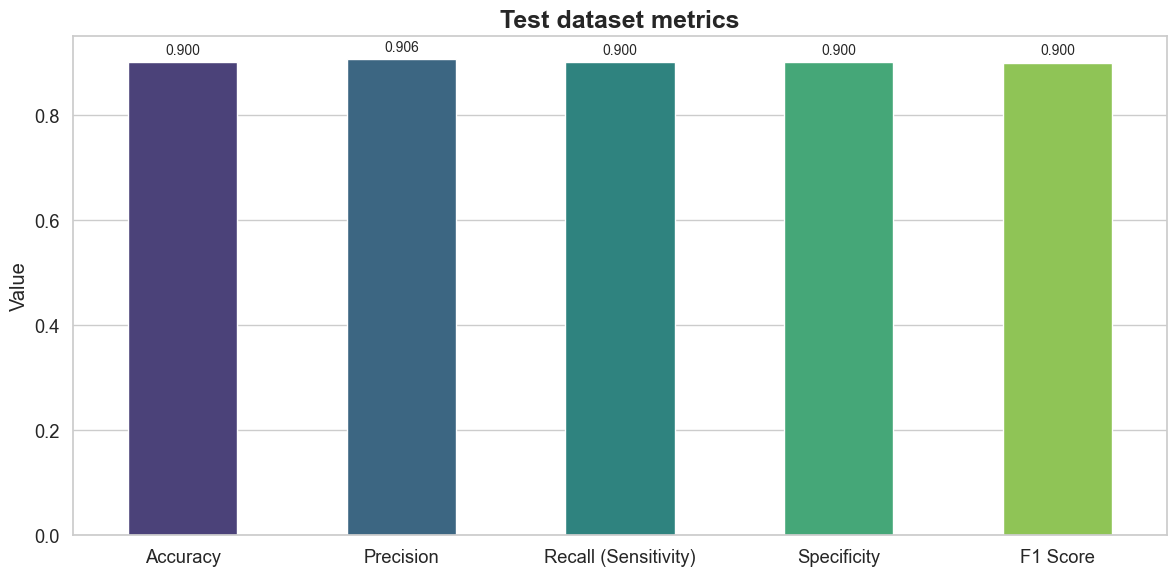

In [185]:
def plot_metrics(y_pred, y_test):
    """
    Generates a bar plot of accuracy, precision, recall (sensitivity), specificity, and F1 score based on the predicted labels and the actual labels.

    Parameters:
        y_pred (array-like): An array object containing the predicted labels.
        y_test (array-like): An array object containing the actual labels.

    Returns:
        None
    """

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')  # Sensitivity
    specificity = specificity_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), hue=list(metrics.keys()), palette="viridis",
                     legend=False)

    # Add the numbers above the bars
    for i, metric in enumerate(metrics.keys()):
        ax.text(i, metrics[metric] + 0.01, f'{metrics[metric]:.3f}', ha='center', va='bottom', fontsize=10)

    plt.title('Test dataset metrics', size=18, fontweight='bold')
    plt.ylabel('Value')
    plt.tight_layout()

    # Make the bars thinner
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - 0.5
        patch.set_width(0.5)
        patch.set_x(patch.get_x() + diff * .5)

    plt.show()

plot_metrics(y_pred_classes, y_test)  # type: ignore

##### Confusion matrix

In [186]:
def ensure_binary_labels(y_pred, y_test):
    """
    Ensures that both predicted and actual labels are binary (0 or 1).
    
    Parameters:
        y_pred: Array-like of predicted values
        y_test: Array-like of actual values
    
    Returns:
        Tuple of (y_pred_binary, y_test_binary)
    """
    def to_binary(y):
        if isinstance(y, (np.ndarray, pd.Series)):
            # If probabilities, convert to binary
            if y.dtype in [np.float32, np.float64]:
                return (y > 0.5).astype(int)
            # If already binary-like
            return y.astype(int)
        return np.array(y, dtype=int)
    
    return to_binary(y_pred), to_binary(y_test)

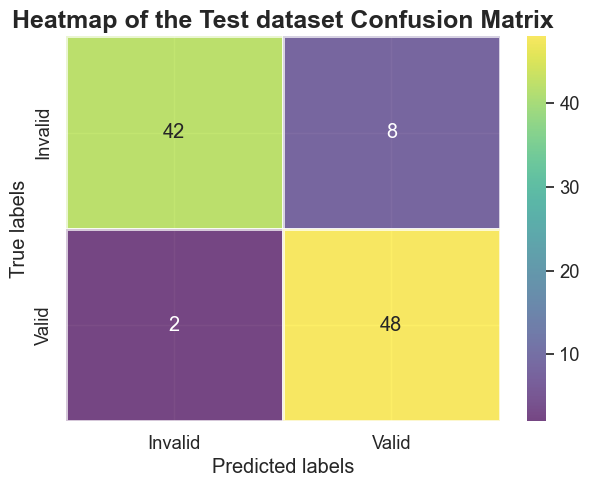

In [187]:
def plot_conf_matrix(y_pred, y_test, labels, return_buffer=False):
    """
    Generates a heatmap of the confusion matrix based on the predicted labels and actual labels.
    
    Parameters:
        y_pred: Array-like of predicted values
        y_test: Array-like of actual values
        labels: List of label names for the confusion matrix
        return_buffer: If True, returns a BytesIO buffer containing the plot
    
    Returns:
        BytesIO if return_buffer is True, None otherwise
    """
    # Convert labels to binary format
    y_pred_binary, y_test_binary = ensure_binary_labels(y_pred, y_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(7, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', alpha=0.7, linewidths=2, 
                xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Heatmap of the Test dataset Confusion Matrix', 
              fontsize=18, fontweight='bold')

    if return_buffer:
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png', dpi=300, bbox_inches='tight')
        img_buf.seek(0)
        plt.close()
        return img_buf
    else:
        plt.show()
        plt.close()
        return None

# Define the labels
labels = ['Invalid', 'Valid'] 
plot_conf_matrix(y_pred_classes, y_test, labels)

##### History results

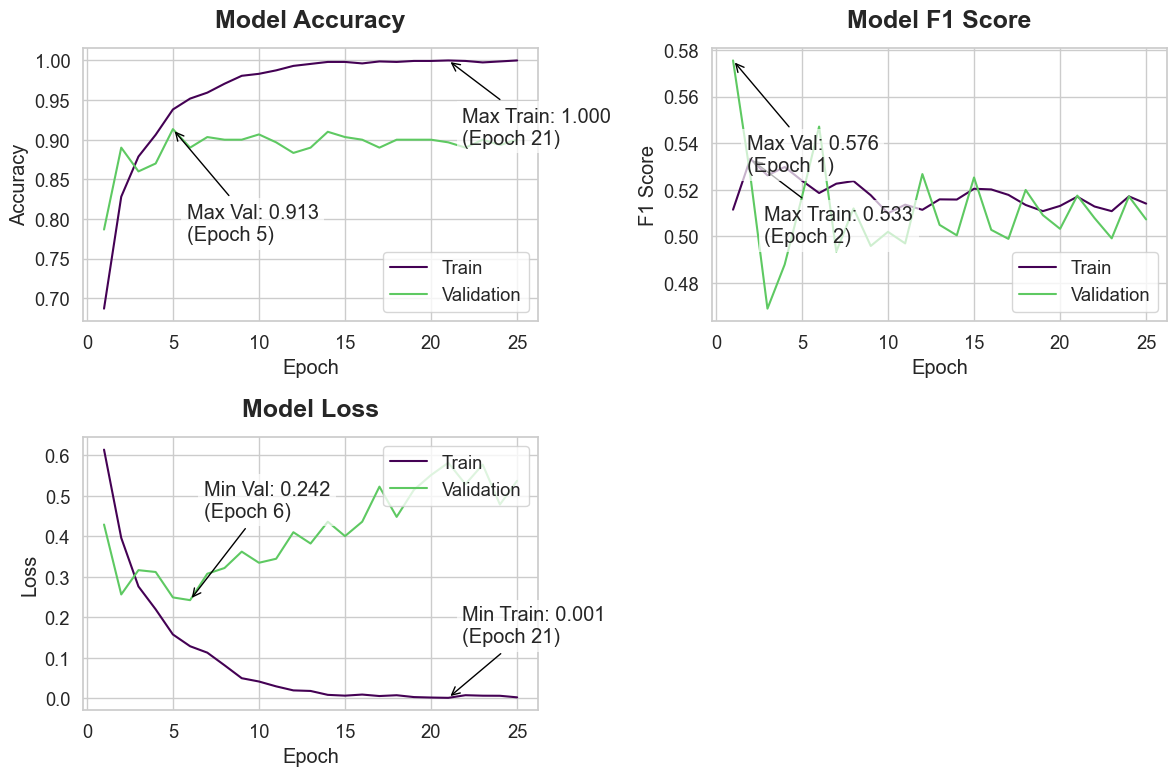

In [188]:
def plot_history(history, return_buffer=False, save_path=None):
    """
    Generate plots to visualize the training and validation metrics over epochs.
    
    Parameters:
        history: A dictionary containing the training history (typically from model.fit())
        return_buffer (bool): If True, returns a BytesIO buffer containing the plot
        save_path (str, optional): Path to save the plot (e.g., 'training_history.png')
    
    Returns:
        BytesIO if return_buffer is True, None otherwise
    """   
    
    # Create epochs list
    epochs = [ep + 1 for ep in history.epoch]
    
    # Set style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    
    # Color scheme
    train_color = '#440154'
    val_color = '#5ec962'
    arrow_color = 'black'
    
    # Helper function for annotations
    def add_annotation(ax, x, y, text, offset_y):
        ax.annotate(text,
                   xy=(x, y),
                   xytext=(10, offset_y),
                   textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', color=arrow_color),
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    # Plot accuracy
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(epochs, history.history['accuracy'], color=train_color, label='Train')
    ax1.plot(epochs, history.history['val_accuracy'], color=val_color, label='Validation')
    ax1.set_title('Model Accuracy', size=18, fontweight='bold', pad=15)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    
    # Accuracy annotations
    max_acc = max(history.history['accuracy'])
    max_val_acc = max(history.history['val_accuracy'])
    add_annotation(ax1, history.history['accuracy'].index(max_acc) + 1, max_acc,
                  f'Max Train: {max_acc:.3f}\n(Epoch {history.history["accuracy"].index(max_acc) + 1})', -60)
    add_annotation(ax1, history.history['val_accuracy'].index(max_val_acc) + 1, max_val_acc,
                  f'Max Val: {max_val_acc:.3f}\n(Epoch {history.history["val_accuracy"].index(max_val_acc) + 1})', -80)
    
    # Plot F1 Score
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(epochs, history.history['f1_score'], color=train_color, label='Train')
    ax2.plot(epochs, history.history['val_f1_score'], color=val_color, label='Validation')
    ax2.set_title('Model F1 Score', size=18, fontweight='bold', pad=15)
    ax2.set_ylabel('F1 Score')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')
    
    # F1 Score annotations
    max_f1 = max(history.history['f1_score'])
    max_val_f1 = max(history.history['val_f1_score'])
    add_annotation(ax2, history.history['f1_score'].index(max_f1) + 1, max_f1,
                  f'Max Train: {max_f1:.3f}\n(Epoch {history.history["f1_score"].index(max_f1) + 1})', -60)
    add_annotation(ax2, history.history['val_f1_score'].index(max_val_f1) + 1, max_val_f1,
                  f'Max Val: {max_val_f1:.3f}\n(Epoch {history.history["val_f1_score"].index(max_val_f1) + 1})', -80)
    
    # Plot loss
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(epochs, history.history['loss'], color=train_color, label='Train')
    ax3.plot(epochs, history.history['val_loss'], color=val_color, label='Validation')
    ax3.set_title('Model Loss', size=18, fontweight='bold', pad=15)
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')
    ax3.legend(loc='upper right')
    
    # Loss annotations
    min_loss = min(history.history['loss'])
    min_val_loss = min(history.history['val_loss'])
    add_annotation(ax3, history.history['loss'].index(min_loss) + 1, min_loss,
                  f'Min Train: {min_loss:.3f}\n(Epoch {history.history["loss"].index(min_loss) + 1})', 40)
    add_annotation(ax3, history.history['val_loss'].index(min_val_loss) + 1, min_val_loss,
                  f'Min Val: {min_val_loss:.3f}\n(Epoch {history.history["val_loss"].index(min_val_loss) + 1})', 60)
    
    plt.tight_layout()
    
    # Handle output
    if save_path:
        filename_history_results = f'History_{metabolite_name}_v{version_str}.png'
        plt.savefig(os.path.join(output_dir, filename_history_results), dpi=300)
        print(f"Plot saved as: History_{metabolite_name}_v{version_str}.png in {output_save_path}")
            
    if return_buffer:
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png', dpi=300, bbox_inches='tight')
        img_buf.seek(0)
        plt.close()  # Close the figure to free memory
        return img_buf
    
    elif plt.isinteractive():
        plt.show()
        plt.close()
    
    return None

plot_history(history) # type: ignore

# Example usage:
# plot_history(history)  # Simple display
# plot_history(history, save_path=True)  # Save to file + display
# buffer = plot_history(history, return_buffer=True)  # Get buffer + display

##### Probability output with associated images

In [189]:
# Warning : each images need to have a different name
def plot_images_with_probabilities(df, probabilities, save_path=None):
    probabilities = np.squeeze(probabilities)
    num_images = len(df)
    grid_size = int(num_images**0.5)
    if grid_size**2 < num_images:
        grid_size += 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(100, 100))
    axes = axes.flatten()

    for i, (_, row) in enumerate(df.iterrows()):
        img = row['Image']
        axes[i].imshow(img)
        axes[i].axis('off')

        # Determine the color based on the probability
        probability = float(probabilities[i])
        if probability >= 0.995:
            color = 'green'
        elif 0.05 < probability < 0.995:
            color = 'orange'
        else:
            color = 'red'

        prob_text = f"{probability * 100:.4f}%"
        axes[i].text(10, 20, prob_text, color='white', fontsize=60,
                     bbox=dict(facecolor=color, alpha=0.5))

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    
    # If save_path is provided, save the figure first
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Show the plot after saving
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

# Usage example:
# Assuming X_test contains the filenames of the test set images
X_test_filenames = X_test.index if hasattr(X_test, 'index') else X_test

# Create a DataFrame for the test set
df_test = df.loc[X_test_filenames]

# Predict probabilities
y_pred_prob = model.predict(X_test_tensor) # type: ignore

# Create the output filename
filename_probability_output = f'probability_output_{metabolite_name}_v{version_str}.png'
output_path = os.path.join(output_dir, filename_probability_output)

# Plot and save in one go
plot_images_with_probabilities(df_test, y_pred_prob, save_path=output_path)

print(f"Plot saved as: {filename_probability_output} in {output_save_path}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Plot saved as: probability_output_ECG_v1.png in c:\Users\Biosfer\Desktop\kaggle_dataset_ECG\models\ECG


#### 9. Excel table compile model result 

In [190]:
def compile_model_results_to_excel(version, model, history, X_test, Y_test, X_test_tensor, Y_test_tensor, 
                                 metabolite_name, y_pred_classes, excel_path=None):
    if excel_path is None:
        excel_path = f'models_results_{metabolite_name}.xlsx'
    matplotlib.use('Agg')
     
    # Load the specific version of the configuration
    try:
        config, version_str = load_config(metabolite_name, version)
    except ValueError as e:
        print(f"Error: {e}")
        return
    except Exception as e:
        print(f"Error loading configuration: {e}")
        return

    # Load existing Excel file or create a new one
    try:
        workbook = openpyxl.load_workbook(excel_path)
    except FileNotFoundError:
        workbook = openpyxl.Workbook()

    # Get or create the sheet for this version
    sheet_name = f'Version {version}'
    if sheet_name in workbook.sheetnames:
        sheet = workbook[sheet_name]
        # Clear the existing content
        for row in sheet[sheet.dimensions]:
            for cell in row:
                cell.value = None
    else:
        sheet = workbook.create_sheet(title=sheet_name)

    # 1. Model Summary
    sheet['A1'] = 'Model Summary'
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    summary_string = "\n".join(stringlist)

    # Save the summary to a temporary text file
    with tempfile.NamedTemporaryFile(delete=False, mode='w', encoding='utf-8', suffix='.txt') as tmpfile:
        tmpfile.write(summary_string)
        tmpfile_path = tmpfile.name

    # Convert the text file to an image
    img_buf = BytesIO()
    plt.figure(figsize=(9, 6))
    plt.text(0.01, 0.99, summary_string, va='top', ha='left', wrap=True, fontsize=10, family='monospace')
    plt.axis('off')
    plt.savefig(img_buf, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close()
    img_buf.seek(0)

    # Insert the image into the Excel sheet
    img = Image(img_buf) # type: ignore
    sheet.add_image(img, 'A2')
        
    # 2. Training History
    sheet['M1'] = 'Training History'
    sheet['M2'] = 'Accuracy'
    sheet['N2'] = 'f1_score'
    sheet['O2'] = 'Loss'
    sheet['P2'] = 'Val Accuracy'
    sheet['Q2'] = 'Val_f1_score'
    sheet['R2'] = 'Val Loss'
    history_df = pd.DataFrame(history.history)
    for r, row in enumerate(history_df.values, start=3):
        for c, value in enumerate(row, start=13):
            sheet.cell(row=r, column=c, value=value)

    # 3. Performance Plots - Using plot_history function
    img_buf = plot_history(history, return_buffer=True)
    # Add the image to the Excel sheet
    img = Image(img_buf) # type: ignore
    img.width, img.height = img.width // 3, img.height // 3  # Reduce image size
    sheet.add_image(img, 'T1')

    # 4. Confusion Matrix
    labels = ['Invalid', 'Valid']
    img_buf = plot_conf_matrix(y_pred, y_test, labels, return_buffer=True)
    
    # Convert buffer to image
    img = Image(img_buf)
    # Adjust image size (you can modify these values)
    img.width = 600
    img.height = 600
    
    # Add the image to the sheet 
    sheet.add_image(img, 'K40')

    # 5. Model Code
    sheet['A35'] = 'Model Code'
    model_code = config.get('code', 'Model code not available') if isinstance(config, dict) else 'Model code not available'
    model_code_lines = model_code.split('\n')
    for i, line in enumerate(model_code_lines, start=36):
        sheet.cell(row=i, column=1, value=line)

    # 6. Training Code
    sheet['A70'] = 'Training Code'
    training_code = config.get('training', 'Training code not available') if isinstance(config, dict) else 'Training code not available'
    training_code_lines = training_code.split('\n')
    for i, line in enumerate(training_code_lines, start=71):
        sheet.cell(row=i, column=1, value=line)

    # Save the workbook
    workbook.save(excel_path)
    print(f"Results for version {version} compiled and saved to {output_save_path} as {excel_path}")


compile_model_results_to_excel(version, model, history, X_test, Y_test, X_test_tensor, Y_test_tensor, # type: ignore
                                 metabolite_name, y_pred_classes)

Results for version 1 compiled and saved to c:\Users\Biosfer\Desktop\kaggle_dataset_ECG\models\ECG as models_results_ECG.xlsx


#### 10. Save the final model

In [191]:
# Save the model
model_save_dir = construct_path(metabolite_name, "models")
model_filename = f'model_{metabolite_name}_v{version_str}.keras'
model_save_path = os.path.join(model_save_dir, model_filename)

os.makedirs(model_save_dir, exist_ok=True)  # Create directory if it doesn't exist
model.save(model_save_path)  # type: ignore

print(f"Model saved as:{model_filename} in {model_save_dir}")

Base directory: c:\Users\Biosfer\Desktop\kaggle_dataset_ECG
Model saved as:model_ECG_v1.keras in c:\Users\Biosfer\Desktop\kaggle_dataset_ECG\models\ECG
